# Task 5: Learning Crowd Dynamics

In [5]:
# All imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math
import utils
from sklearn.decomposition import PCA
from scipy.interpolate import RBFInterpolator

%reload_ext autoreload
%autoreload 2

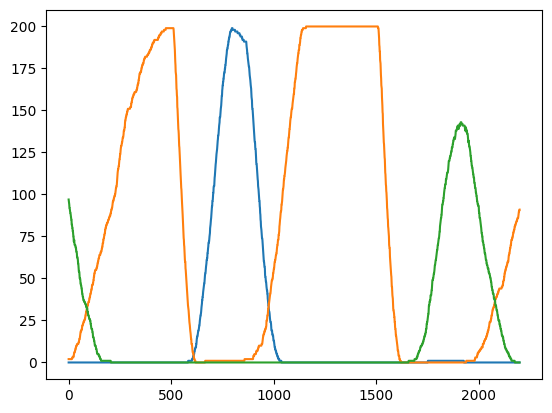

In [6]:
data = np.loadtxt('../../data/MI_timesteps.txt')
data_1 = data[1000:, 1:4]
#plt.plot(data_1[:,0],data_1[:,1])
#plt.plot(data_1[:,0],data_1[:,2])
#plt.plot(data_1[:,0],data_1[:,3])
plt.plot(data_1[:2200])

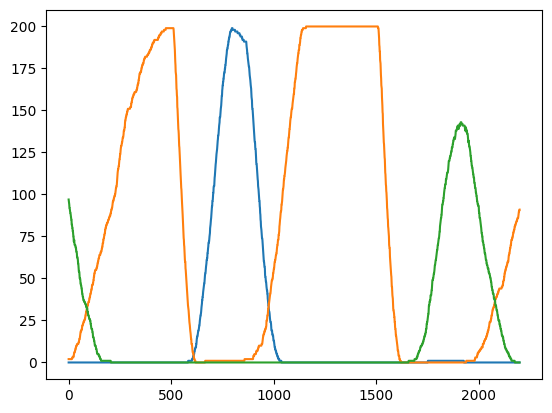

In [7]:
#plt.plot(data_1[:,0],data_1[:,1])
#plt.plot(data_1[:,0],data_1[:,2])
#plt.plot(data_1[:,0],data_1[:,3])
plt.plot(data_1[:2200])

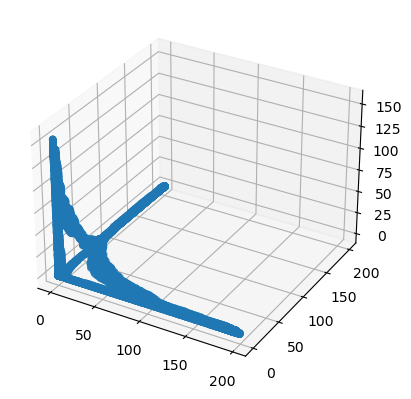

In [79]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(*data_1.T)
plt.show()

### TODO: Task 5.1 - Create a delay embedding with 350 delays of the first three measurement areas

In [10]:
# Number of delays
num_delays = 350
num_areas = 3  # Columns per window
# Create delay windows
windows = utils.create_windows(data_1, num_delays, num_areas)

In [11]:
windows_centered = utils.center_data(windows)

In [12]:
# TODO: Compute SVD
#U, S, Vt = utils.compute_svd(windows_centered)

In [13]:
pca = PCA(n_components=3)  # Choose the number of components you want to keep
principal_components = pca.fit_transform(windows)

In [14]:
principal_components.shape

(13651, 3)

### TODO: Task 5.2 - Create 9 plots - one for each measurement area

In [17]:
#take original measurement data ignoring 1000 timesteps burn-in period, loading the 9 measurements areas data
x_original = data[1000:,1:]

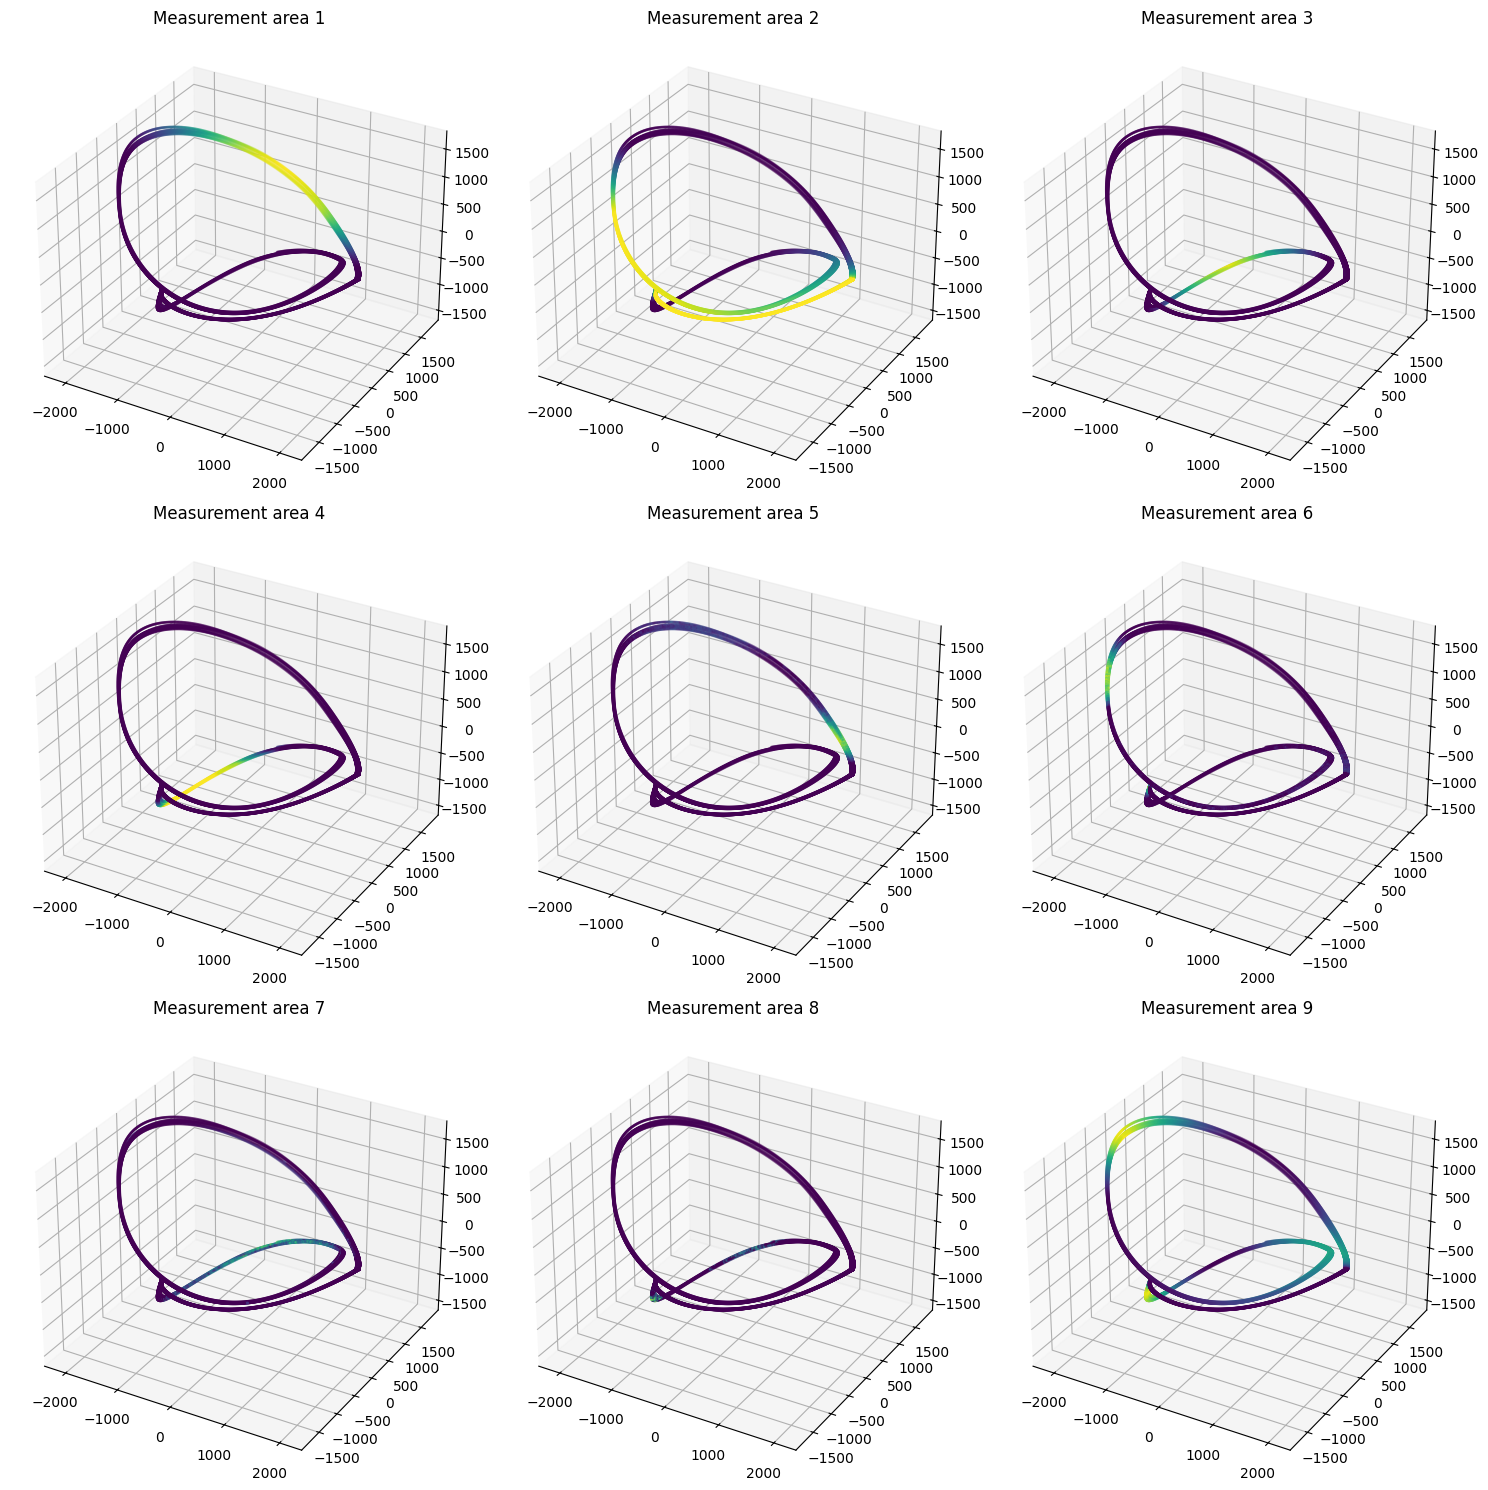

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), subplot_kw={'projection': '3d'})
for i in range(9):
    row = i // 3  # Determine row index (0, 1, 2)
    col = i % 3   # Determine column index (0, 1, 2)
    ax = axs[row,col]
    ax.scatter(*principal_components.T, s=1, c=x_original[:len(principal_components), i])
    ax.set_title('Measurement area ' + str(i+1))
    #plt.show()

plt.tight_layout()
plt.show()

### TODO: Task 5.3 - Learn the dynamics on the periodic curve you embedded in the principal components.

In [21]:
# Compute arclengths
arclengths = np.zeros(len(principal_components))
for i in range(1, len(principal_components)):
    arclengths[i] = arclengths[i-1] + np.linalg.norm(principal_components[i] - principal_components[i-1])

In [22]:
# Compute change of arclength over time
change_of_arclength = np.diff(arclengths)

(0.0, 25000.0)

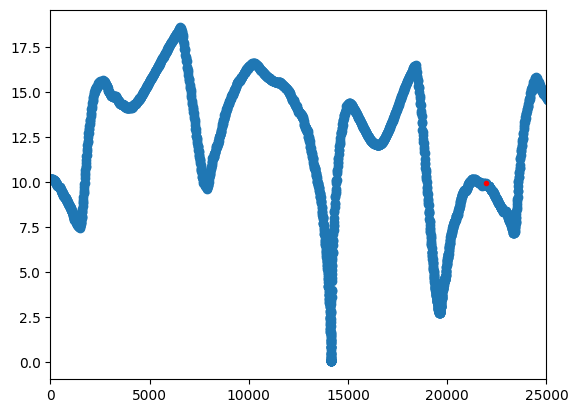

In [35]:
#ground truth
plt.scatter(arclengths[:-1], change_of_arclength)
plt.scatter(arclengths[2000], change_of_arclength[2000],marker='.', color='r')
plt.xlim(0,25000)

We can indentify a period of roughly 2000 timesteps (1 day)

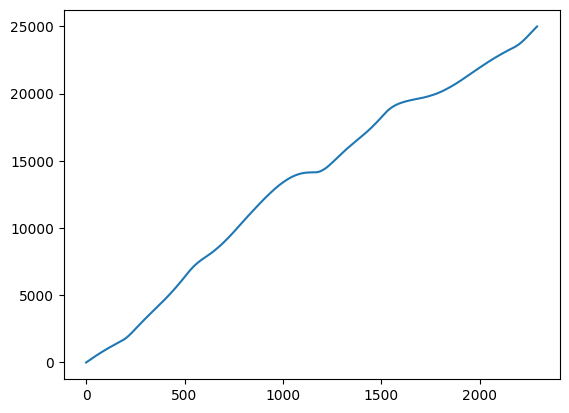

In [24]:
plt.plot(np.where(arclengths <= 25000)[0],arclengths[:len(np.where(arclengths <= 25000)[0])])
#plt.ylim(0,25000)

In [89]:
#total length of the PCA curved arc
arclengths[-1]

array([149454.2841094])

In [42]:
change_of_arclength.reshape(len(change_of_arclength),1)
arclengths = arclengths.reshape(len(arclengths),1)

In [92]:
L = 2000
#x = np.linspace(-4.5, 4.5, L)
centers = arclengths[-1]*np.random.random_sample((L,1))

In [95]:
phi = utils.approx_non_linear_field(arclengths[:2001],centers, 0.015)
C =  utils.least_squares(phi.T, change_of_arclength[:2001])
approx_field = np.dot(phi.T, C)
def g(t, y):
    phi_ = utils.approx_non_linear_field(y,centers, 0.185)
    C =  utils.least_squares(phi_.T, v)
    return np.dot(phi_.T,C).flatten()

utils.mean_squared_error(change_of_arclength[:2001].reshape(2001,1), approx_field.reshape(len(approx_field),1))

0.1469364113642776

In [101]:
phi = utils.approx_non_linear_field(arclengths[:-1],centers, 0.015)
C =  utils.least_squares(phi.T, change_of_arclength)
approx_field_2 = np.dot(phi.T, C)

utils.mean_squared_error(change_of_arclength.reshape(len(change_of_arclength),1), approx_field_2.reshape(len(approx_field_2),1))

2.913755163530583

(0.0, 50000.0)

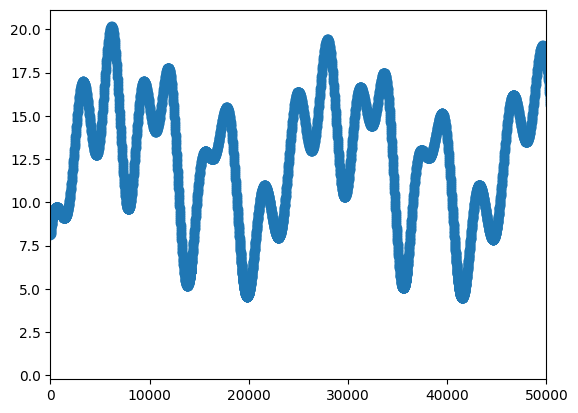

In [102]:
# approximation
plt.scatter(arclengths[:-1], approx_field_2)
plt.xlim(0,50000)

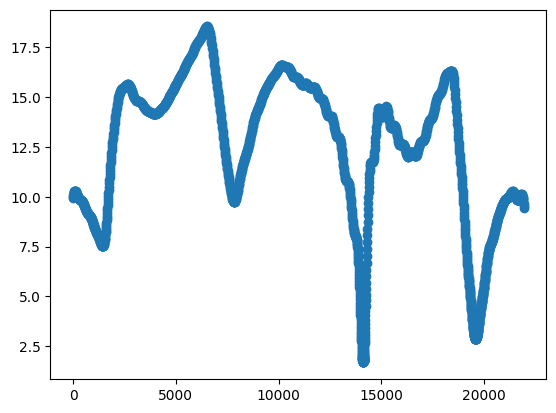

In [80]:
# approximation
plt.scatter(arclengths[:2001], approx_field)

### TODO: Task 5.4 Prediction of utilization of the MI building 

We need to integrate the arclength vector field over time to get a prediction of the arclength values.

In [25]:
# Hint : Use nonlin_func_approx from utils to compute utilization value by using radial basis function 
num_prediction = (len(data_1))
period = arclengths[2000]

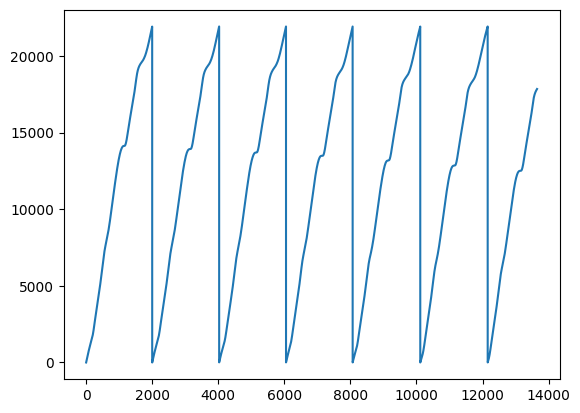

In [26]:
#arclength over the periodic curve embedded in the PCA
plt.plot(arclengths % period)

In [183]:
arclengths_period = arclengths % period

In [27]:
# measurement are number 1, MI building
MI_data = data_1[:,0:1]

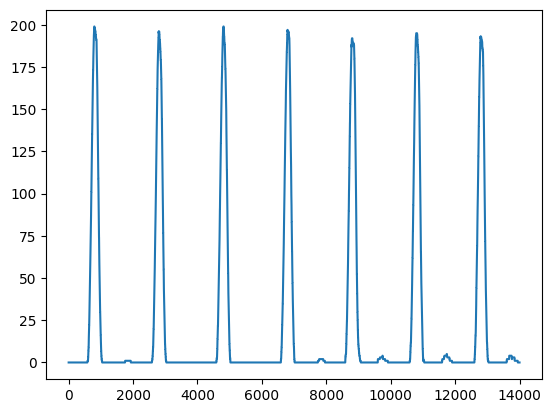

In [82]:
plt.plot(MI_data)

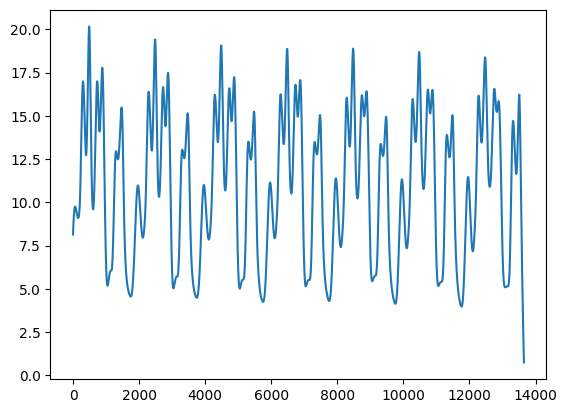

In [104]:
plt.plot(approx_field_2)

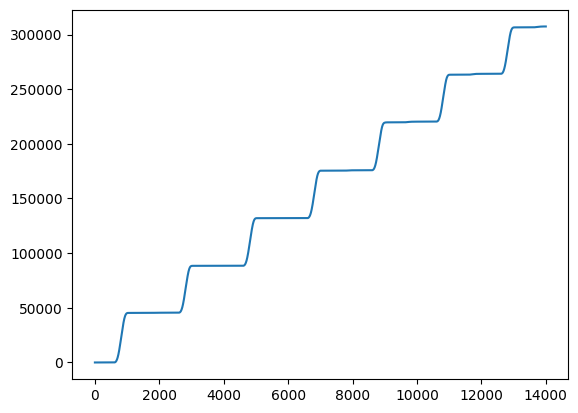

In [85]:
plt.plot(np.cumsum(MI_data))

predicted_arclengths = np.zeros(len(arclengths))
predicted_arclengths[0] = arclengths_period[-1]

for i in range(1, len(arclengths)):
    print(i)
    predicted_arclengths[i] = predicted_arclengths[i-1] + change_of_arclength[i-1]

In [30]:
# define f, f(t,y)= dy/dt where y is the arclength
def f(t,y):
    pass

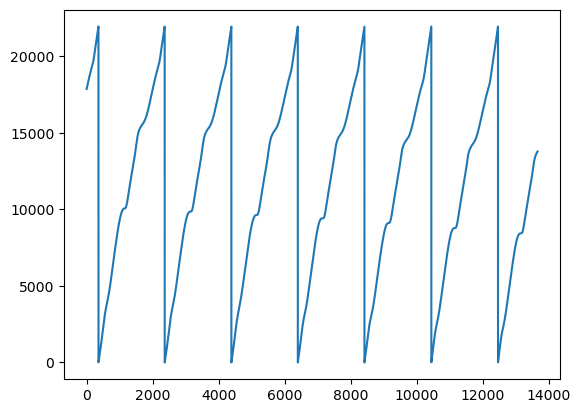

In [204]:
solve_ivp()

In [213]:
predicted_arclength_period =predicted_arclengths % period

In [106]:
approx_field_2 = approx_field_2.reshape((len(approx_field_2),1))

In [118]:
np.cumsum(approx_field_2).s

(13650,)

In [122]:
predicted_MI = RBFInterpolator(np.cumsum(approx_field_2).reshape(len(approx_field_2),1), MI_data[0:len(approx_field_2)],
                                kernel='gaussian', epsilon=0.08)(np.cumsum(approx_field_2).reshape(len(approx_field_2),1))

utils.mean_squared_error(predicted_MI,MI_data[:len(predicted_MI)])

7.463772505433255e-13

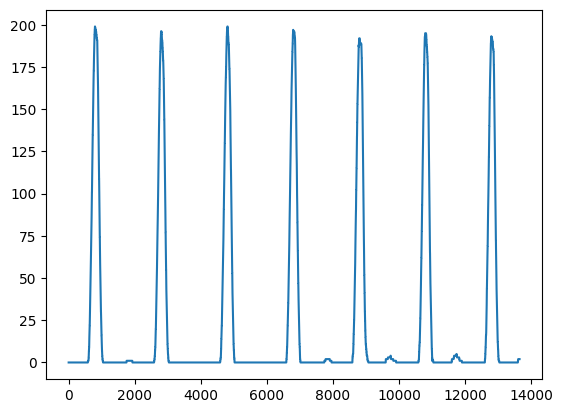

In [123]:
plt.plot(predicted_MI)

In [115]:
predicted_MI

array([[4.53871455e+17],
       [5.76806161e+17],
       [4.83917661e+17],
       ...,
       [6.75302999e+17],
       [7.59506689e+17],
       [8.07427774e+17]])